# Social Media and Human-Computer Interaction - Part 1

###  *Goal*: Learn how to retrieve, manage, and save social media posts.

Specifically, we will retrieve, annotate, process, and interpret Twitter data on health-related issues such as depression.

--- 
References:
* [Mining Twitter Data with Python (Part 1: Collecting data)](https://marcobonzanini.com/2015/03/02/mining-twitter-data-with-python-part-1/)
* The [Tweepy Python API for Twitter](http://www.tweepy.org/)

Required Software
* [Python 3](https://www.python.org)
* [NumPy](http://www.numpy.org) - for preparing data for plotting
* [Matplotlib](https://matplotlib.org) - plots and garphs
* [jsonpickle](https://jsonpickle.github.io) for storing tweets. 
---

In [1]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import jsonpickle
import json
import random
import time
import tweepy

# Introduction

Analysis of social-media discussions has grown to be an important tool for biomedical informatics researchers, particularly for addressing questions relevant to public perceptions of health and related matters. Studies have examination of a range of topics at the intersection of health and social media, including studies of how [Facebook might be used to commuication health information](http://www.jmir.org/2016/8/e218/) how Tweets might be used to understand how smokers perceive [e-cigarettes, hookahs and other emerging smoking products](https://www.jmir.org/2013/8/e174/), and many others.

Although each investigation has unique aspects, studies of social media generally share several common tasks. Data acquisition is often the first challenge: although some data may be freely available, there are often [limits](https://dev.twitter.com/rest/public/rate-limits) as to how much data can be queried easily. Researchers might look out for [opportunities for accessing larger amounts of data](https://www.wired.com/2014/02/twitter-promises-share-secrets-academia/). Some studies contract with [commercial services providing fee-based access](https://gnip.com). 

Once a data set is hand, the next step is often to identify key terms and phrases relating to the research question. Messages might be annotated to indicate specific categorizations of interest - indicating, for example, if a message referred to a certain aspect of a disease or symptom. Similarly, key words and phrases regularly occurring in the content might also be identified. Natural language and text processing techniques might be used to extract key words, phrases, and relationships, and machine learning tools might be used to build classifiers capable of distinguishing between types of tweets of interest. 

This module presents a preliminary overview of these techniques, using Python 3 and several auxiliary libraries to explore the application of these techniques to Twitter data. 
  
  1. Configuration of tools to access Twitter data
  2. Twitter data retrieval
  3. Searching for tweets

Our case study will apply these topics to Twitter discussions of smoking and tobacco. Although details of the tools used to access data and the format and content of the data may differ for various services, the strategies and procedures used to analyze the data will generalize to other tools.

## 1. Configuration of tools to access Twitter data

[Twitter](www.twitter.com) provides limited capabilities for searching tweets through an Application Programming Interface (API) based on Representational State Transfer (REST).  [REST](https://doi.org/10.1145/337180.337228) is an approach to using web-based Hypertext-Transfer Protocol (HTTP) requests as APIs. 

Essentially, a REST API specifies conventions for HTTP requests that might be used to retrieve specific data items from a remote server. Unlike traditional HTTP requests, which return HTML markup to be rendered in web browsers, REST APIs return data formatted in XML or JSON, suitable for interpretation by computer programs. REST APIs from familiar websites underlie frequently-seen functionality such as embedded twitter widgets and "like/share" links, among others.

Commercial REST applications often use "API-Keys" - unique identifiers used to associate requests with registered accounts. Here, we will walk through the process of registering for Twitter API keys and using a Python library to manage the details of making a Twitter API request and receiving a response.

1.1 Registering for a Twitter API key

1.1.1 *Signup for Twitter* The first step in registering for a Twitter API key is to [signup](https://twitter.com/signup) for an account. If you dont' want to post anything or to use the account in any way that might be linked to your regular email adddress, you might want to create a special-purpose account using a service such as gmail, and use this new email address for the twitter account.

1.1.2. *Create a Twitter application*: Go to  [Twitter's developer site](https://dev.twitter.com) and click on "My Apps". Click on "Create New App" in the upper right and then fill out the form. The main thing that you need to focus on here is the application name, description, and website. The rest can be ignored.

Creating the application will lead to the display of some information with some URLs and a few tabs. Look under "Keys and Access Tokens" to see the Consumer API key and API Secret - these will come in handy later.

There will also be a button that says "Create my access token". Press this button and make a note of the Access Token and Access Token Secret values that are displayed. 

Although hese tokens are always available on the application page, for the purpose of this exercise, it's best to store them in Python variables directly in this Jupyter notebook. Execute the following insstructions, substituting the keys for your application for the phrases "YOUR-CONSUMER-KEY", etc. 

In [2]:
consumer_key = 'YOUR-CONSUMER-KEY'
consumer_secret = 'YOUR-CONSUMER-SECRET'
access_token = 'YOUR-ACCESS-TOKEN'
access_secret = 'YOUR-ACCESS-SECRET'

### *Note that the following should be redacted*

In [3]:
consumer_key='D2L4YZ2YrO1PMix7uKUK63b8H'
consumer_secret='losRw9T8zb6VT3TEJ9JHmmhAmn1GXKVj30dkiMv9vjhXuiWek9'
access_token='15283934-iggs1hiZAPI2o5sfHWMfjumTF7SvytHPjpPRGf3I6'
access_secret='bOvqssxS97PGPwXHQZxk83KtAcDyLhRLgdQaokCdVvwFi'

In theory, you know have all that you need to start accessing Twitter. Using these keys and the information in the [Twitter Developer Documentation](https://dev.twitter.com/docs), you might conceivably create web requests to search for tweets, post, and read your timeline. In practice, it's a bit more complicated, so most folks use third-party tools that take care of the hard work. 

1.1.3 *Try the Tweepy library*: [Tweepy](http://www.tweepy.org) is a Python 3 library for using the Twitter API. Like other similar libraries - there are many for Python and other languages - Tweepy takes care of the details of authorization and provides a few simple function calls for accessing the API.  

The first step in using Tweepy is *authorization* - establishing your credentials for using the Twitter API. Tweepy uses the [OAuth](http://www.oauth.net) authorization framework, which is widely used for both API and user access to services provided over HTTP. Fortunately Tweepy hides the oauth details. All you need to do is to make a few calls to the Tweepy library and you're all set to go. Run the following code, making sure that the four variables are set to the values you were given when you registered your Twitter application:

In [4]:
from tweepy import OAuthHandler

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

If this worked correctly, you should see something like this 
```
<tweepy.api.API at 0x109da36d8>
``` 

If you get an error message, please check your keys and tokens to ensure that they are correct.

## 2. Twitter data retrieval

Now that you have successfully accessed the Twitter API, it's time to access the data. The simplest thing to do is to grab some Tweets off of your timeline. Try the following code:

In [5]:
top_ten = []
i =0
for tweet in tweepy.Cursor(api.home_timeline).items(10):
    top_ten.append(tweet._json)
    

There are several key componnents to this block of code:
* ```api.home_timeline``` is a component of the API object, referring to the user timeline - the tweets shown on your home page.
* ```tweepy.Cursor``` is a construct in the Tweepy API that supports navigation through a large set of results.
* ```tweepy.Cursor(api.home_timeline).items(10)``` essentially asks Tweepy to set up a cursor for the home timeline and then to get the first 10 items in that set. The result is a Python Iterator, which can be used to examine the items in the set in turn.
* We will grab the JSON representation of each tweet (stored as "tweet.\_json") for maximum flexibility.
* The loop takes each of those objects an adds them into a Python array.

Now, each of the items in ```top_ten``` is a Tweet object. Let's take a look inside. We'll start by grabbing the first text:

In [6]:
tweet1=top_ten[0]

and looking at its text:

In [7]:
tweet1['text']

'MAJOR BREAKING NEWS (h/t @MarchForTruth17): Fusion GPS Transcript Released: https://t.co/vkZsIarWKY https://t.co/M9hTA409eG'

.. noting that the text is roughly 140 characters long...

In [8]:
len(tweet1['text'])

123

We can also examine when the tweet was created...

In [9]:
tweet1['created_at']

'Tue Jan 09 18:35:53 +0000 2018'

.. whether it has been favorited...

In [10]:
tweet1['favorited']

False

.. The unique ID String of the Tweet...

In [11]:
tweet1['id_str']

'950798294699167744'

.. and the name of the Twitter user responsible for the post. 

In [12]:
tweet1['user']['name']

'Seth Abramson'

In [13]:
tweet1=top_ten[1]

In [14]:
tweet1['id_str']

'950798273937371136'

We can check to see if a tweet is a retweet by seeing if it has the 'retweeted_status' attribute.

In [15]:
'retweeted_status' in tweet1

True

You can also see if your tweet was a retweet. If it was, the <em>retweeted_status</em> field will hold information about the original tweet

In [16]:

if 'retweeted_status' in tweet1:
    original = tweet1['retweeted_status']
    print(original['user']['name'])
else:
    print("not a rewteet")

Katie Bo Williams


The twitter API supports many other details for users, tweets, and other entities. See [The Twitter API Overview](https://dev.twitter.com/overview/api) for general details and subpages about [Tweets](https://dev.twitter.com/overview/api/tweets), [Users](https://dev.twitter.com/overview/api/users) and related pages for specific details of other data types.

## 3. Searching for tweets

Our next major goal will be to search for Tweets. Effective searching requires both construction of useful queries (the hard part) and use of the Tweepy search API (the easy part).

### 3.1 Formulating a query

Formulating an effective search query is often a challenging, iterative process. Trying some searches in the Twitter web page is a good way to see both how a query might be formulated and which queries might be most useful.

If you look carefully at the URL bar in your browser after running a search, you might notice that the search term is embedded in the URL. Thus, if you search for "depression", you might see a URL that looks like https://twitter.com/search?q=depression. You might also see "&src=typed" at the end of the URL, indicating that the search was typed by hand.

You can also use Tweepy to conduct a search, as follows:

In [17]:
tlist = api.search("smoking",lang="en",count=10)
tweets = [t._json for t in tlist]

This search will find the first 10 English tweets matching the term "depression".

In [18]:
tweets[0]['text']

'RT @Mariselllla: Smoking a fat ass blunt in full glam in a bomb ass fit just makes you feel like the baddest bitch in the world'

We can then look at the text for these tweets. This is a good way to check to ensure that we're getting what we think we should be getting.

In [19]:
texts = [c['text'] for c in tweets]

In [20]:
texts

['RT @Mariselllla: Smoking a fat ass blunt in full glam in a bomb ass fit just makes you feel like the baddest bitch in the world',
 'RT @MsDiplodocus: Why is smoking attractive',
 'RT @anandvardhan26: Romanticisation of Old Monk by people gulping cerebral income is similar to smoking being eligibility for joining fashi…',
 'RT @mineifiwildout: that boy tito from rocket power was 1200% smoking big gas before work every day https://t.co/Em8v15kPME',
 'yooo, smoking and vibin to the weekend is a must \U0001f919🏽',
 "RT @ThickyThickBaes: Can't forget the #Thick Asian twerking while smoking a blunt with chopsticks. This is definitely in the top 5 twerk vi…",
 'I hope this opens your ears about Gov Corruption ...... Smoking Gun in Bundy Trial - Rep. Matt Shea Exposes BLM Atr… https://t.co/l683UdBguU',
 'church hardcore smoking adult https://t.co/vefJm5mEeH',
 "RT @ThickyThickBaes: Can't forget the #Thick Asian twerking while smoking a blunt with chopsticks. This is definitely in the top 5 t

You may see some tweets that don't match exactly - perhaps using 'depressed' instead of 'depression'. This suggests that Twitter uses <em>stemming</em> - removing suffixes and variations to get to the core of the word - to increase search accuracy.

At this point, we should be able to evaluate the results to see if we are on the right track. If we aren't, we'd want to try some different queries. For now, it looks good, so let's move on.

### 3.2 Collecting and characterizing a larger corpus

Our original query only retrieved 10 tweets. This is a good start, but probably not enough for anything serious. We can loop through several times to create a longer list, with a delay between searches to avoid overstaying our welcome with Twitter:

In [21]:

for i in range(10):
    new_tweets = api.search("smoking",lang="en",count=100)
    nt = [t._json for t in new_tweets]
    tweets= tweets+nt
    time.sleep(5)
    

In [22]:
len(tweets)

1010

At this point, we might want to know something about the tweets that we have retrieved. As our goal is to shoot for linguistic diversity, we want to make sure that we don't have too many retweets, and that we have a wide range of authors. Let's run through the tweets and count the number of authors and retweets. We can count authors in a dictionary and retweets in a simple variable.

In [23]:
def getAuthors(tweets):
    authors={}
    retweets=0
    for t in tweets:
        # is it a retweet? If so, increment
        if 'retweeted_status' in t:
            retweets = retweets+1
        # get tweet author name
        uname = t['user']['name']
        # if not in authors, put it in with zero articles
        if uname not in authors:
            authors[uname]=0
        authors[uname]=authors[uname]+1
    return (retweets,authors)

In [24]:
(retweets,authors) = getAuthors(tweets)
retweets

731

In [25]:
len(tweets)

1010

In [26]:
len(authors.keys())

155

We might see a lot of retweets here - I saw at least 80% in one instance, with about 193 authors. This suggests that this corpus has a good many authors with multiple tweets. 

To explore this, let's look at the histogram of the number of tweets/author.

To examine the distribution of authors, we can use the [NumPy](http://www.numpy.org) and [Matplotlib](http://matplotlib.org) libraries to extract the number of tweets from each user (given by authors.values()) and to plot a histogram...

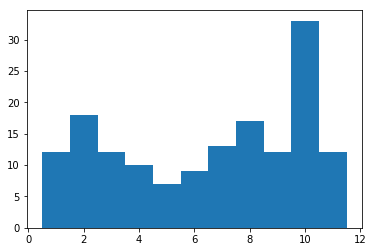

In [27]:
vals = np.array(list(authors.values()))
#plt.xticks(range(min(vals),max(vals)+1))
plt.hist(vals,np.arange(min(vals)-0.5,max(vals)+1.5));

It looks like a broad range of the number of tweets/user, up until roughly tweets, with many users having 10 tweets. This is an intersting pattern, with no immediately obvious interpretation. Understanding the usage patterns might be an intersting area for further work, although larger data sets might be necessary to see meaningful patterns.

Given the number of retweets and the frequency of posting by some authors, we might be concnered that we are seeing repeated tweets.  To check this, we will review the  tweet IDs in a manner similar to that  which we used for the authors, to see how many of the tweets are unique. 

As we do this, we'll create a dictionary that will allow us to retrieve tweets by IDs. Specifically, we will create a new diectionary entitled Each `utweets`. This dictionary will be indexed by the ID string of the tweet. Each element of the dictionary will itself be a dictionary, withe the following contents:

* 'tweet' will refer to the full tweet
* 'count' contains the number of times it occurs in the dataset. 

Later, we'll add to this structure. 

In a more complete program, we might use Object-Oriented programming to wrap the data in a [Python Class](https://docs.python.org/3/tutorial/classes.html), but that would add more complexity that we don't want to get into here. 

For now, we'll proceed by building up the dictionary of tweets.

In [28]:
utweets={}
for t in tweets:
    id = t['id_str']
    if id not in utweets:
        new_entry={}
        new_entry['count']=0
        new_entry['tweet']=t
        utweets[id]=new_entry
        
    utweets[id]['count']=utweets[id]['count']+1
len(utweets)

157

Now, we can turn this dictionary into a list of id, count pairs, sort by count, and see which ones were repeated most often.

In [29]:
ps = []
for t,entry in utweets.items():
    count = entry['count']
    ps.append((t,count))  
ps.sort(key=lambda x: x[1],reverse=True)

Hmm.. only a small portion of our tweets are unique

In [30]:
float(len(utweets))/float(len(tweets))

0.15544554455445544

let's take a look at the most common

In [31]:
ps[1:10]

[('950798278836277248', 11),
 ('950798293713367040', 11),
 ('950798334201131011', 11),
 ('950798311346204672', 11),
 ('950798338906931200', 11),
 ('950798264059809793', 11),
 ('950798280325259265', 11),
 ('950798327498489856', 11),
 ('950798315406290944', 11)]

So, many tweets were seen 10 or more times. Let's take a look at them

In [32]:
for i in range(10):
    idstr = ps[i][0]
    count = ps[i][1]
    tweet = utweets[idstr]['tweet']
    text= tweet['text']
    print(idstr+" "+text+" "+str(count))

950798299187044353 RT @ThickyThickBaes: Can't forget the #Thick Asian twerking while smoking a blunt with chopsticks. This is definitely in the top 5 twerk vi… 11
950798278836277248 RT @ThickyThickBaes: Can't forget the #Thick Asian twerking while smoking a blunt with chopsticks. This is definitely in the top 5 twerk vi… 11
950798293713367040 I hope this opens your ears about Gov Corruption ...... Smoking Gun in Bundy Trial - Rep. Matt Shea Exposes BLM Atr… https://t.co/l683UdBguU 11
950798334201131011 RT @MsDiplodocus: Why is smoking attractive 11
950798311346204672 yooo, smoking and vibin to the weekend is a must 🤙🏽 11
950798338906931200 RT @Mariselllla: Smoking a fat ass blunt in full glam in a bomb ass fit just makes you feel like the baddest bitch in the world 11
950798264059809793 i am so proud of myself for not smoking cigarettes no more. 🚭 11
950798280325259265 church hardcore smoking adult https://t.co/vefJm5mEeH 11
950798327498489856 RT @anandvardhan26: Romanticisation of Old

This leads to a question - how can we generate a large set of unique tweets, so as to ensure diversity of results? Our techniques for checking uniquness provide an answer. We can retrieve tweets, checking as we go to see if we've seen them before, and discaring tweets that are repeats. This will continue until we have a large enough set.

To do this, we'll have a structure similar to what we used before: 
* tweets will be a dictionary, keyed by the id string of the tweet
* each entry will include a count of the number of times that tweeet was seen, and the tweet itself

This may seem a bit cumbersome, but there's an advantage - if we use a structure like this, it becomes very easy to store it to disk, providing a dataset that can easily be shared and reused.

Finally, we can store this in a function, allowing us to re-run the search for a different set of terms.

In [33]:

def searchTwitter(term,corpus_size):
    tweets={}
    while (len(tweets) < corpus_size):
        new_tweets = api.search(term,lang="en",count=10)
        for nt_json in new_tweets:
            nt = nt_json._json
            if nt['id_str'] not in tweets:
                new_entry={}
                new_entry['count']=0
                new_entry['tweet']=nt
                tweets[nt['id_str']]=new_entry
            tweets[nt['id_str']]['count'] = tweets[nt['id_str']]['count']+1
        # wait to give our twitter account a break..
        time.sleep(5)
    return tweets

As this routine makes multiple search calls and pauses after each, it might take some time to complete.  Trails have identified running times in the range of 3-4 minutes.  Give it a try and see how long it takes you.

In [34]:
tweets = searchTwitter("smoking",100)

### 3.3 Saving tweets, Loading tweets, and Verifying results

Now, we've got a good solid set of tweets to work with. Let's save these tweets to a file, using the [jsonpickle](https://jsonpickle.github.io/) library to convert the strucure into a json file, which we will then write to disk. We'll define a function to do this, as we might want to repeat this later.

In [35]:
def saveTweets(tweets,filename):
    json_data =jsonpickle.encode(tweets)
    with open(filename,'w') as f:
        json.dump(json_data,f)

In [36]:
saveTweets(tweets,'tweet.json')

Now that that's done, we can read it in again. Once again, we'll write a function.

In [57]:
def readTweets(filename):
    with open(filename,'r') as f:
        json_data = json.load(f)
    tweets = jsonpickle.decode(json_data)
    return tweets

Let's  do some quick checks to confirm that we've got the right data out. Note that in future runs, you can just start here to read in your tweets.

In [58]:
tweets2 = readTweets('tweet.json')

In [59]:
len(tweets2)

100

In [60]:
tweets == tweets2

True

[According to Python documentation](https://docs.python.org/2/reference/expressions.html#id24) dictionaries are equal if the keys and values are equal, so this looks good. To check in more detail, we can look at the keys, using subtraction to indicate set difference:

In [41]:
tweets.keys()-tweets2.keys()

set()

To confirm, we might look specifically at some tweets.. we'll  find an ID and grab the structures out of each list, reviewing for comparable values.

In [42]:
tweet_id=random.choice(list(tweets.keys()))

In [43]:
t1 = tweets[tweet_id]
t2= tweets2[tweet_id]

In [44]:
t1['tweet']['text']

'RT @TheTimeIGotHigh: They’re smoking weed on CNN 2018’s about to be fucking crazy\n https://t.co/8s6GNwca3t'

In [45]:
t2['tweet']['text']

'RT @TheTimeIGotHigh: They’re smoking weed on CNN 2018’s about to be fucking crazy\n https://t.co/8s6GNwca3t'

In [46]:
t1==t2

True

Spot checks like this give some confidence that the loaded tweets are identical to the saved tweets. We might also run a slightly more rigorous check by iterating through the list to look for similarities. Since we know that the two dictionaries have identical sets of keys, we can iterate through the keys of one to get entries and compare equalities.

In [47]:
errs =[]
for id in tweets.keys():
    t1 =tweets[id]
    t2 = tweets2[id]
    if t1 != t2:
        errs.append(id)

In [48]:
errs

[]

Great. No errors...

***

## Exercise 1.1: Dataset diversity

Having collected a data set, we might want to characterize it in different ways. We saw above how to identify the number of authors represented in a set of tweets. Here, we examine a slightly different question - what is the elapsed time period covered by a set of tweets? In other words, what are the  times of the first and last tweets in the set?

To do this, we'll need some help from Python libraries. Before we get into that, let's get a couple of tweets from our set. 

### 1.1.1 Introduction

In [61]:
tid1=random.choice(list(tweets.keys()))
tid2=random.choice(list(tweets.keys()))
tweet1=tweets[tid1]['tweet']
tweet2=tweets[tid2]['tweet']

We can now look at their creation times.

In [62]:
tweet1['created_at']

'Tue Jan 09 18:39:50 +0000 2018'

In [63]:
tweet2['created_at']

'Tue Jan 09 18:40:15 +0000 2018'

We can use the python [datetime](https://docs.python.org/2/library/datetime.html) library, and the *strptime* function in particular to convert these strings to datetime objects capable of being compared and manipulated. 

In [64]:
from datetime import datetime

to do this, we call *strptime* with a string pattern matchings of the strings returned in the tweet object. Specifically, we can see that each timestamp has a 3 letter string indicating a day of the week, the month, the date, the time in hh:mm:ss format, a time-zone indicate ("+000") and the year. These items can be specified in a string argument as "%a" ," "%b", "%d", "%H", "%M", "%S", "%z" and "%Y", respectively, thus providing a pattern to be used to create the time object, as follows:

In [65]:
t1 = datetime.strptime(tweet1['created_at'], "%a %b %d %H:%M:%S %z %Y")

In [66]:
t1

datetime.datetime(2018, 1, 9, 18, 39, 50, tzinfo=datetime.timezone.utc)

In [67]:
t2 = datetime.strptime(tweet2['created_at'], "%a %b %d %H:%M:%S %z %Y")

we can then find the difference between the two:

In [68]:
t2-t1

datetime.timedelta(0, 25)

You can also take these *datetime* objects and convert them into dates, which then might be compared.

In [69]:
t2.date() == t1.date()

True

### 1.1. Min and Max

Find the times of the minimum (earliest) and maximum (latest) tweets in the collection.

*ANSWER FOLLOWS - cut below here*

In [70]:
def getExtremes(tweets):
    times = []
    for id in tweets.keys():
        ctimestring = tweets[id]['tweet']['created_at']
        ctime = datetime.strptime(ctimestring,"%a %b %d %H:%M:%S %z %Y")
        times.append(ctime)
    mint = min(times) 
    maxt = max(times)
    return (mint,maxt)    
    
(mint,maxt) = getExtremes(tweets)
print(mint)
print(maxt)

2018-01-09 18:36:56+00:00
2018-01-09 18:40:21+00:00


*END CUT*
****

### 1.2 Frequency

Write a routine to find the distribution of the teets in the set by date. You might do this by creating a dictionary that has the dates of tweets as keys.  This routine will be very similar to the routine written above to count the number of tweets by author.

Note that for this dataset you will probably have all tweets coming from the same date. However, your routine should be generally enough to find the number of tweets for any date represented in the dataset.

*ANSWER FOLLOWS - cut below here*

In [71]:
def getDateFrequency(tweets):
    dates={}
    for id in tweets.keys():
        ctimestring = tweets[id]['tweet']['created_at']
        ctime = datetime.strptime(ctimestring,"%a %b %d %H:%M:%S %z %Y")
        cdate = ctime.date()
        if cdate not in dates:
            dates[cdate]=0
        dates[cdate]=dates[cdate]+1
    return dates

In [72]:
dfreq = getDateFrequency(tweets)
len(dfreq)

1

In [73]:
keys=list(dfreq.keys())

In [74]:
d1=keys[0]
d1

datetime.date(2018, 1, 9)

In [75]:
dfreq[d1]

100

In [76]:
len(tweets)

100

*END CUT*

### 1.3 Other forms of data diversity

The open-ended nature of social media makes true sampling almost impossible. Unlike sampling based on geographical constraints such as place of residence, data sampled from social media does not draw from any well-characterized population. More simply stated, we might know how many people live in a city or town, but we don't know how many people might have tweeted on a given topic at any given time. 

However, we can look at the data to ensure that has some diversity. Our exploration of authors provides one example:
a data set with a range of authors may cover more topics than one with a much smaller number of authors. Diversity of dates and times might help in the same way.  
                                                                                                                                                                                    The following questions will encourage you to think about other forms of data diversity. 
                                                                                                                                                                                    
#### 1.3.1  Why might diversity  of times be of interest?                                                                                                                                 

*ANSWER FOLLOWS - cut below here*

Tweets might contain different content at different times of days, different days of the week, of even based on season.  For example, discussions of recreational drug use might be more common on evenings and weekends, just as tweets about skiing and snowstorms might be more likely in winter.  

*END CUT*

#### 1.3.2  How might you ensure a diversity of times?

*ANSWER FOLLOWS - cut below here*

Collecting a much larger corpus over weeks or months will cover a range of times. If longitudinal collection of tweets over many months is prohibitively difficult, you might try collecting snapshots - perhaps 100 or 1000 tweets/day over a course of time.  

*END CUT*

#### 1.3.3 What other forms of data diversity might be of interest, and how might they be achieved?

*ANSWER FOLLOWS - cut below here*

Geographic diversity is important if you want to exmaine differences in patterns across different regions or countries. 
This [stack overflow post](https://stackoverflow.com/questions/20169467/how-to-convert-from-longitude-and-latitude-to-country-or-city) discusses how you might convert longitude/latitude information available in tweets into states and regions.

Other cases might require tweets from a range of languages. The 'lang' attribute of tweet indicates the language in which it was written.

In either case, you might proceed as we did with unique tweet IDs. Simply continue trying to search until you get a braod enough range of values for your questions of interest.

*END CUT*
***

## 3.4 Some final notes
Note that we might find that we will want to add additional fields to this file. We can always rewreite the file as needed. Saving the file as is gives us a good record that we can work from, without having to recreate the dataset. 

Now that you've mastered the basics of retrieving Twitter data, you can move on to [Part 2](SocialMedia - Part 2.ipynb).